In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
import math 
import qutip as qt
from scipy.optimize import curve_fit

from scipy.stats import norm

import scipy.integrate as integrate

from scipy.signal import argrelextrema #Til opgave 2a

import seaborn
# set theme
seaborn.set_style('ticks')


# The von Neumann model

In this worksheet we will investigate weak measurement with a qubit system and a free particle as a meter. The hamiltonian is 

$$H=H_S\otimes1+1 \otimes H_M  + H_{SM} = \frac{\epsilon}{2} \hat{\sigma}_z \otimes \mathbf{1}+ \mathbf{1}\otimes \frac{\hat{p}^2}{2m} + g \delta(t)\hat{\sigma}_z \otimes \hat{p}$$

The system is analogue to light passing trough a birefringent crystal or a spin 1/2 particle in a single Stern Gerlach experiment. The meter system is treated as a photographic plate but the gaussian wave function is also common in more technical measurement devises like a quantum point contact. We first introduce the theoretical predictions learned from the Quantum Measurement book and thereafter the simulate the system using the stochastic master equation. 


## Theoretical overview

The state of the whole system is a direct product of the system state and the meter state $\ket{\Psi}=\ket{\psi}_S\otimes \ket{\phi}_M$. Instead of the classical collapse of a wave function using projective measurement, we have a partial collapse where it is only the meter that collapses to a state $\ket{x}_M$. Using the Heisenberg picture the state immediatly after the delta interaction at $t=0$ is 

$$\ket{\tilde{\Psi}}= \hat{U}_{SM}\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M  = \exp(-ig\hat{\sigma}_z \otimes \hat{p}/\hbar)\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M$$

Writing in terms of the basis of the system hamiltonian and recognizing the translation operator we get a measurement operator 

$$\Omega_x \equiv _M\langle x \mid \hat{U}_{SM} \ket{\tilde{\phi}}_M = \mid + \rangle_S \langle + \mid \phi(x-g) + \mid - \rangle_S \langle - \mid \phi(x+g)$$

Where the $\phi(x)$ is the position representation of the meter state:

$$\phi(x)=\braket{x \mid\phi} = \frac{1}{(2\pi \sigma^2)^{1/2}} \exp(-\frac{x^2}{4\sigma^2})$$

But through measurement $\braket{x \mid\phi} = \delta (t)$ right...? For measurement outcome $x$ the particle starting in  $\ket{\tilde{\psi}}=a\ket{+}+b\ket{-}$ is in state

$$P_x = \mid \mid \Omega_x \ket{\psi} \mid \mid^2$$
The meter starts in a eigenstate of the system $\phi(x)$ which is a gausian with center at the origin. The post measurement state will collaps the meter to the value $x$ and the system state s 

$$\ket{\psi'}= \frac{\Omega_x \ket{\psi}}{\mid \mid \Omega_x \ket{\psi} \mid \mid}$$

From the initial value of the system:

$$\ket{\tilde{\psi}}_S=a\ket{+}+b\ket{+}$$

Does the coeficients here depend of time...? They most have some wiggle factor

$$\ket{\tilde{\psi}}_S=\mathrm{e}^{-iH_st}(a_0\ket{+}+b_0\ket{-})$$


In [3]:
#Initial parameters for system and meter  
a0 = 1/(np.sqrt(2)) #system initial coefficient plus polarized 
b0 = np.sqrt(1-a0**2)#1/(np.sqrt(2)) #system initial coefficient mins polarized 
sigma = 1 #standard deviation of meter's initial wave function

In [4]:
X_span = np.linspace(-10,10,250)

def phi(x,sig=sigma):
    return  norm.pdf(x, 0, sig) #1.0 / (np.power(2.0 * np.pi*sig**2,0.25)) * np.exp(-np.power((x) / 2*sig, 2.0) / 4)  

def p(x,g,a,b): #probability of measurement outcome x
    if np.isscalar(a):
        return  (a**2) * (phi(x-g)**2) + (b**2) * (phi(x+g)**2)
    elif len(x) != len(a):
        # shape (N_sim, len(x))
        return (a**2)[:,None] * (phi(x-g)[None,:])**2  + (b**2)[:,None] * (phi(x + g)[None,:])**2 
    else: # case N_sim = len(x)
        return (a**2) * (phi(x-g))**2  + (b**2) * (phi(x + g))**2

def cplus(x,g, a,b):#coeficent of plus state post single measurement
    return a * phi(x - g) / np.sqrt(p(x, g, a, b))
    

def cminus(x,g,a,b): #coeficent of minus state post single measurement
    return b * phi(x + g) / np.sqrt(p(x, g, a, b))
   

In [5]:
gstrong = sigma*4 #much bigger than deviation of position 
gweak = sigma/4 #much bigger than deviation of position 

exp_x_strong = integrate.quad(lambda x: x*p(x,gstrong,a0,b0), -10, 10)[0]
exp_x_weak = integrate.quad(lambda x: x*p(x,gweak,a0,b0), -10, 10)[0]

print(f"normalization: {exp_x_weak}, {exp_x_strong}")

normalization: -1.0367571602329879e-17, -2.178075080573672e-16


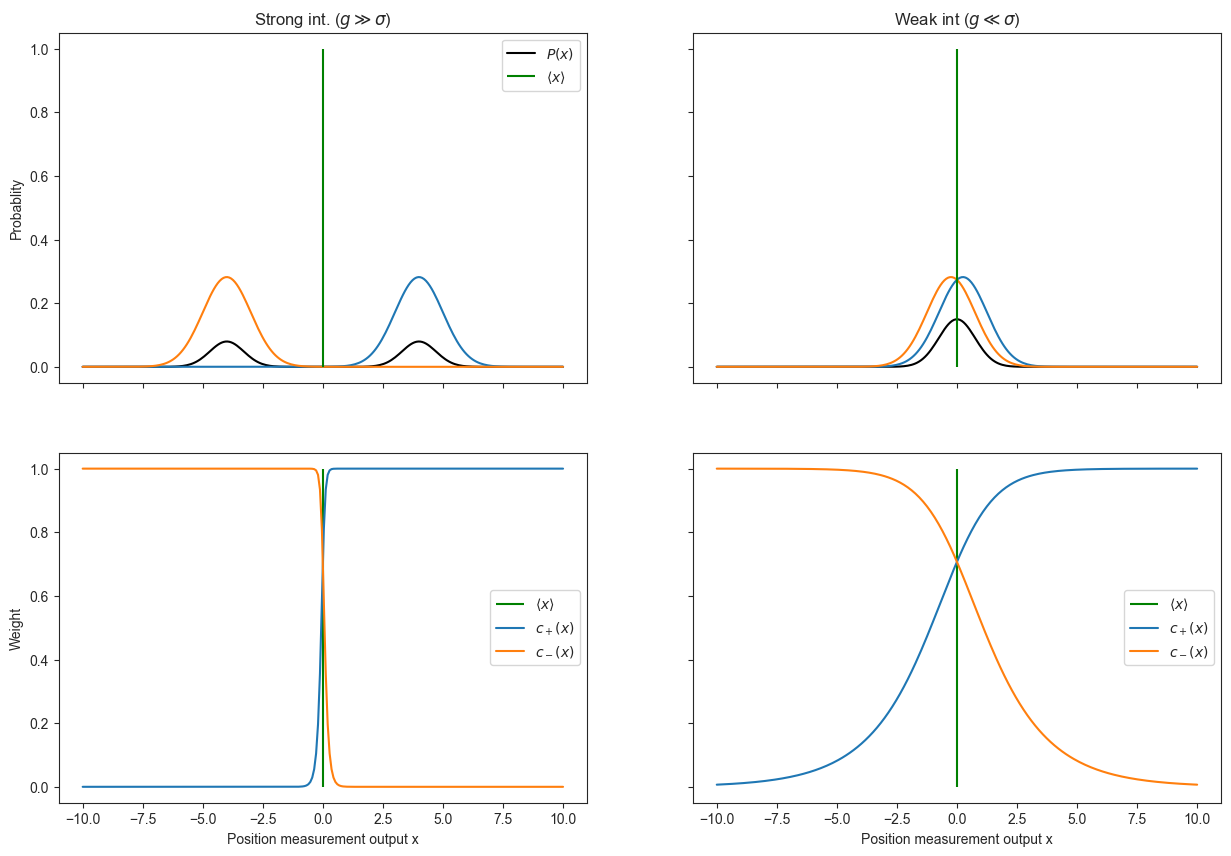

In [6]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,10))

# set figsize

ax[0,0].set_title(f'Strong int. ($g\gg\sigma$)')
ax[0,0].plot(X_span,p(X_span,gstrong,a0,b0),color='Black',label=f'$P(x)$')
ax[0,0].plot(X_span,a0*phi(X_span-gstrong))
ax[0,0].plot(X_span,b0*phi(X_span+gstrong))
ax[0,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,0].plot(X_span,cplus(X_span,gstrong,a0,b0),label = f'$c_+(x)$')
ax[1,0].plot(X_span,cminus(X_span,gstrong,a0,b0),label = f'$c_-(x)$')

ax[1,0].set_xlabel('Position measurement output x')

ax[0,0].legend()
ax[1,0].legend()



ax[0,1].set_title(f'Weak int ($g\ll\sigma$)')
ax[0,1].plot(X_span,p(X_span,gweak,a0,b0),color='Black')
ax[0,1].plot(X_span,a0*phi(X_span-gweak))
ax[0,1].plot(X_span,b0*phi(X_span+gweak))

ax[0,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,1].plot(X_span,cplus(X_span,gweak,a0,b0),label = f'$c_+(x)$')
ax[1,1].plot(X_span,cminus(X_span,gweak,a0,b0),label = f'$c_-(x)$')

ax[0,0].set_ylabel('Probablity')
ax[1,0].set_ylabel('Weight')
ax[1,1].set_xlabel('Position measurement output x')


ax[1,1].legend()
plt.show()

Now the the simulaton we want to see the dynamics of a measurements, say the expectationvalue of x $\exp{x(t)}$. But since the system hamiltonian commutes with the interaction term, any measurement of the system will not change the state of the system - it is a . Two sequential measurements have the same possible measurement outcome as a single measurement. We therefore expect the expectation value of the position is constant:

In [7]:
#sanity check: integrate.quad(lambda x: p(x,gstrong,a,b), -10, 10)

## Random walk simulation using wavefunction (not mixed state) 

Now we will have multiple sequential measurements of the system, like having severial identical stern gerlach experiements/birefringent crystals. We take $N$ measurements with $\Delta t$ time inbetween each measurement. The i'th measurement will give us:

* Time step $t_j = t_{j-1}+\Delta t$
* Position measurement $x_i$ taken from the distribution $P(x,a_{i-1},b_{i-1})$. We add a Weiner process from a gausian - might not be important since we already draw x from a gaussian, but it might give a nice way to learn how to include other noise?
* Post measurement state, by updating the coeficitens $$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

Which ultimately will give us 3 lists $\{x_i\}, \{a_i\}, \{b_i\}$ through a time evolution t. 


In [8]:
N = 150 #Number of measurements per simulation
delta_t = 1 #time between each measurement, relative to system evolution (compare with epsiplon)
t_span = np.linspace(0,delta_t*N,N+1)

In [9]:
def Xeuler_sim(N_sim, N, g, a0=a0 ,b0=b0):#
    '''
    Random walk with fixed step size, in a neaumann system. Can run multiple simulations at once.

    Input:
    N_sim: number of simulations
    N: number of measurements per simulation
    g: interaction strength
    a0: initial state coefficient plus
    b0: initial state coefficient minus

    Output:
    X: array with the particle position measurement at different time steps - measurement record.
    a: array with the particle state coefficient plus at different time steps.
    b: array with the particle state coefficient minus at different time steps.


    '''
    X = np.zeros((N_sim, N)) #spot to plug in new position, one less measurement than states (starts and ends with states
    a = np.zeros((N_sim, N+1)) #coeficitent in plus state
    b = np.zeros((N_sim, N+1)) #coeficitent in minus state

    #Initial conditions
    a[:,0] = np.repeat(a0,N_sim)
    b[:,0] = np.repeat(b0,N_sim)

#    X[0] = #np.random.choice(X_span,p=p(X_span,gstrong,a[0],b[0])/p(X_span,gstrong,a[0],b[0]).sum()) #First measurement
    for i in range(N):
        
        P = p(X_span,gweak,a[:,i],b[:,i])
        P = P/P.sum(axis=1)[:,None]
        X[:, i] = np.array([np.random.choice(X_span,p=P[i,:]) for i in range(N_sim)])#Collect position measurement from the previus state, do not depend directly on the prevues position measurement!
        a[:,i+1] = cplus(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
        b[:,i+1] = cminus(X[:,i],g,a[:,i],b[:,i])
    return X,a,b

Now running N_sim simulations, calibrated so we see a steady state solution

In [10]:
N_sim = 500 #number of simulations

X_ensembe_weak,a_ensembe_weak, b_ensembe_weak  = Xeuler_sim(N_sim, N,gweak, a0, b0)  #X_sim(N_sim,N,gweak,a0=a0,b0=b0)
Pa_ensembe_weak_mean = np.mean(a_ensembe_weak**2,axis=0)
Pb_ensembe_weak_mean = np.mean(b_ensembe_weak**2,axis=0)
X_ensembe_weak_mean = np.mean(X_ensembe_weak,axis=0)

X_ensembe_strong,a_ensembe_strong, b_ensembe_strong  = Xeuler_sim(N_sim,N,gstrong,a0,b0)
Pa_ensembe_strong_mean = np.mean(a_ensembe_strong**2,axis=0)
Pb_ensembe_strong_mean = np.mean(b_ensembe_strong**2,axis=0)

In [11]:
# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, t_span, Pa_ensembe_weak_mean)
c0 = popt[0]
tc = 1/popt[1]
h = popt[2]

/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_24996/320626246.py:2: RuntimeWarning: overflow encountered in exp
  popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(-b * t) + c, t_span, Pa_ensembe_weak_mean)


Now the strong is not that interesting. 

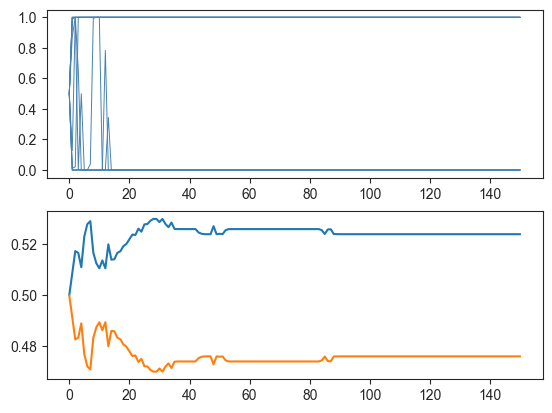

In [12]:
fig, ax = plt.subplots(2)

ax[0].plot(t_span,a_ensembe_strong[10]**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
for i in a_ensembe_strong[:10]: ax[0].plot(t_span,i**2,color='steelblue',linewidth=0.7)

ax[1].plot(t_span,Pa_ensembe_strong_mean,label = r'$\langle P_+(t) \rangle$')
ax[1].plot(t_span,Pb_ensembe_strong_mean,label = r'$\langle P_-(t) \rangle$')
plt.show()

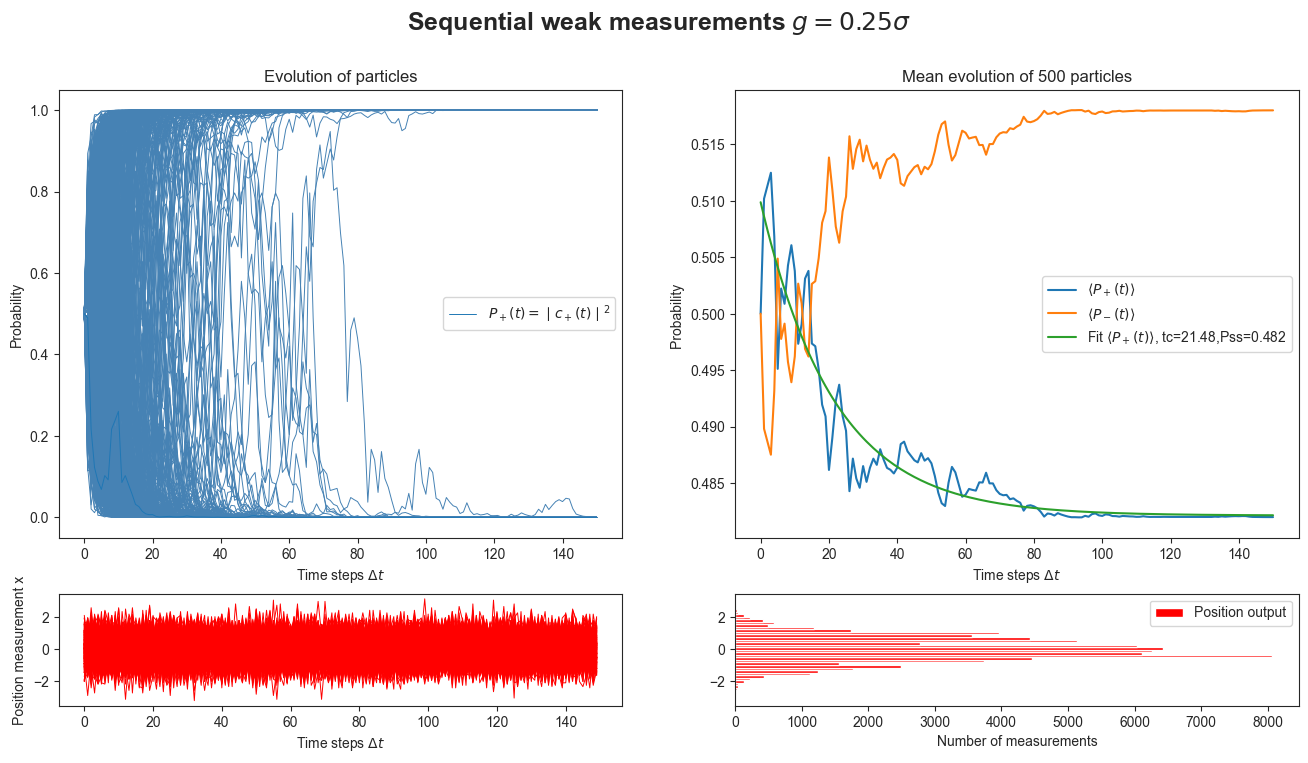

In [13]:
fig, ax = plt.subplots(2, 2,gridspec_kw={'height_ratios': [4,1]},figsize=(16,8))

plt.suptitle(fr'Sequential weak measurements $g={gweak/sigma}\sigma$', fontsize=18,fontweight="bold")

ax[0,0].set_xlabel(r"Time steps $\Delta t$");
ax[0,0].set_ylabel(r'Probability')

ax[1,0].set_xlabel(r"Time steps $\Delta t$");
ax[1,0].set_ylabel(r'Position measurement x')

ax[0,1].set_xlabel(r"Time steps $\Delta t$");
ax[0,1].set_ylabel(r'Probability ')

ax[1,1].set_xlabel(r"Number of measurements");

ax[0,0].set_title('Evolution of particles')
ax[0,1].set_title(f'Mean evolution of {N_sim} particles')

for i in a_ensembe_weak: ax[0,0].plot(t_span,i**2,color='steelblue',linewidth=0.7)
#for i in a_ensembe_strong: ax[0,0].plot(t_span,i,color = 'green',linewidth=0.7)

ax[0,0].plot(t_span,a_ensembe_weak[10]**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
#ax[0,0].plot(t_span,a_ensembe_strong[10],color = 'green',linewidth=0.7,label = f'Strong measurement experiments g={gstrong}')

#plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=2)

for i in X_ensembe_weak: 
    ax[1,0].plot(t_span[:-1],i,color='red',linewidth=0.7)
#for i in X_ensembe_strong[:-1]: ax[1,0].plot(t_span[:-1],i,color = 'green',linewidth=0.7)

ax[0,1].plot(t_span,Pa_ensembe_weak_mean,label = r'$\langle P_+(t) \rangle$')
ax[0,1].plot(t_span,Pb_ensembe_weak_mean,label = r'$\langle P_-(t) \rangle$')
ax[0,1].plot(t_span,c0*np.exp(-t_span/tc)+h,label = fr'Fit $\langle P_+(t) \rangle$, tc={round(tc,2)},Pss={round(h,3)}')

ax[1,1].hist(np.concatenate(X_ensembe_weak),bins=40,orientation='horizontal',color='red',label='Position output')

ax[0,0].legend()
ax[0,1].legend()
ax[1,1].legend()


plt.show()
#print(fr'$\sigma$ =%.2f'%(sigma))

fig.savefig(f'figures/gweak{gweak}sigma_Nsim{N_sim}.pdf')

plot the change of $a$ and $b$ density functions over time

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 150.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
         0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ]),
 <BarContainer object of 30 artists>)

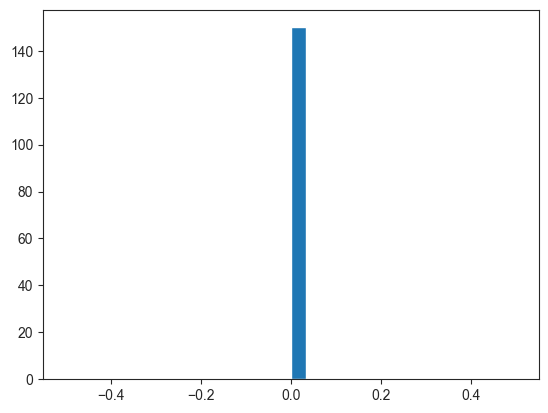

In [41]:
plt.hist(np.sum(X_ensembe_weak[:0,:],axis=0), bins =30)


/var/folders/0k/ps_0pzxs5czcpbh2xf25k20c0000gp/T/ipykernel_24996/1851092703.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x1084eeca0> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'numpy.ndarray' object has no attribute 'set_xdata'

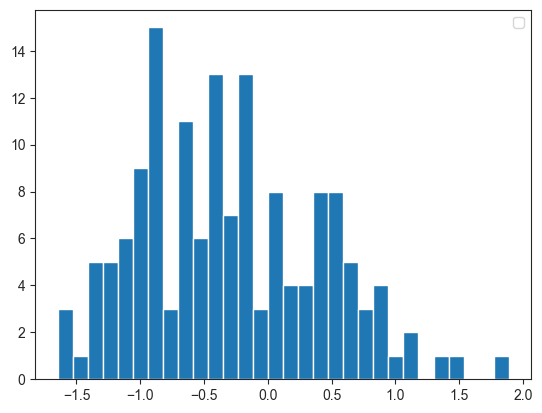

In [45]:

#plt.hist(np.sum(X_ensembe_weak,axis=1), bins =30)
#plt.show()

from matplotlib.animation import FuncAnimation
from IPython.display import Image

sim = np.random.randint(0,N_sim)

fig, ax = plt.subplots()
hist = ax.hist(np.sum(X_ensembe_weak[:1,:],axis=0), bins =30)
plt.legend()


def animate(i):
    
    ax.set_xdata(np.sum(X_ensembe_weak[:sim,:],axis=1))

    return hist,



ani = FuncAnimation(fig = fig,func = animate, frames=np.arange(N_sim), interval=1)
ani.save("movie1.gif")
plt.close()

display(Image(data=open('movie1.gif','rb').read(), format='png'))


In [24]:
X_ensembe_weak[i].shape

(150,)

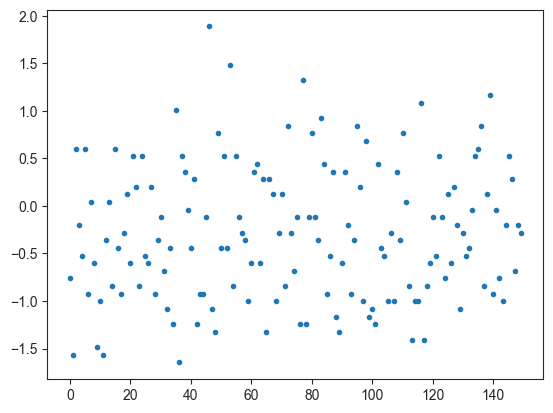

In [32]:
plt.plot(t_span[:-1], X_ensembe_weak[0], '.')

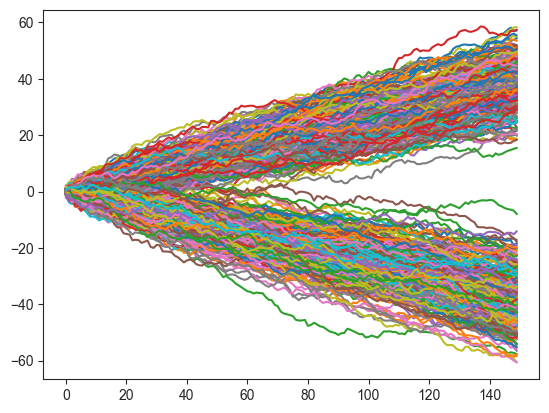

In [29]:
# cum sum of the measurements
for i in range(N_sim): 
    plt.plot(t_span[:-1],np.cumsum(X_ensembe_weak[i,]).T)
plt.show()


Bredden af gauss er prop med sqrt(N)(antal målinger), afstand ml målingerne er prop med N. 

Tag X postion for enkelt måling og forudse om tilstanden er 0 eller 1. lav supervised learning ved at feede med  x positioner hvor vi ved tilstanden er 0 (go derefter med 1)

MovieWriter ffmpeg unavailable; using Pillow instead.


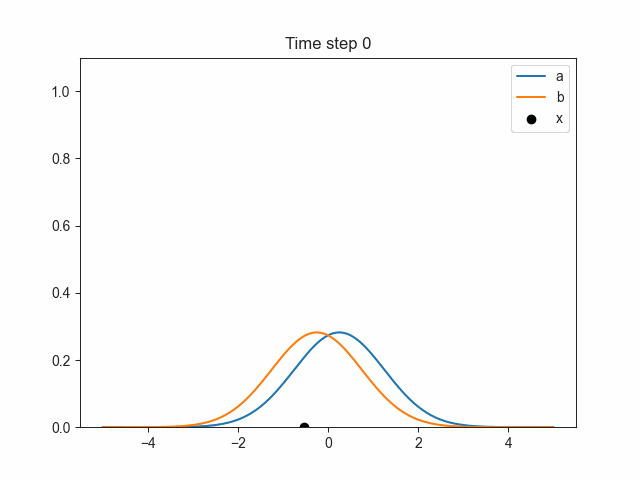

In [137]:
from matplotlib.animation import FuncAnimation
from IPython.display import Image

sim = np.random.randint(0,N_sim)
X_span = np.linspace(-5,5,250)

fig, ax = plt.subplots()
line1, = ax.plot(X_span, a0*phi(X_span-gweak), label = 'a')
line2, = ax.plot(X_span, b0*phi(X_span+gweak), label = 'b')
point = ax.scatter(X_ensembe_weak[sim,0],0,color = 'black', label = 'x')

plt.legend()
ax.set_ylim(0,1.1)

def animate(i):
    a = a_ensembe_weak[sim,i]
    b = b_ensembe_weak[sim,i]
    line1.set_ydata(a*phi(X_span-gweak))
    line2.set_ydata(b*phi(X_span+gweak))
    point.set_offsets([X_ensembe_weak[sim,i],0])
    ax.set_title(f"Time step {i}")

    return (line1, line2, point),



ani = FuncAnimation(fig = fig,func = animate, frames=np.arange(80), interval=1)
ani.save("movie.gif")
plt.close()

display(Image(data=open('movie.gif','rb').read(), format='png'))



The probalility in figure (0,0) should be interpreted as the probalitity to measure + polarization is we where to plug in a projective measurement of the system right after the weak measurement! Perhaps another variable would be better? Like the expectationvalue of the system hamiltonian...?

In [126]:
2*gweak

0.5

Plot (0,0) med sandsynligheder istedet c+^2 og c-^2
Udfør et par sanity check (f.eks. a=0 eller strong measurements istedet)

Undersøg nærmere: 
- hvad er tidskalaen for steady state? (nok noget ala henfaldsraten)
- Omskriv til mixed states 

In [127]:
tc,h,c0

(np.float64(24.140558840035613),
 np.float64(0.4273530393015276),
 np.float64(0.06389056855398093))

In [128]:
nmaxplus = argrelextrema(a0*phi(X_span-gweak),np.greater)[0]#finder maximum


In [129]:
a0*phi(X_span-gweak)[nmaxplus]

array([0.28207759])

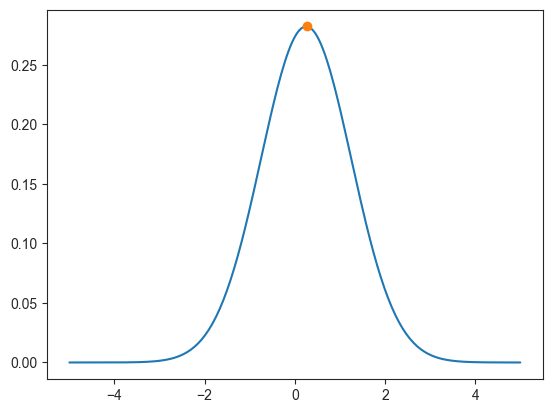

In [130]:
plt.plot(X_span,a0*phi(X_span-gweak))
plt.plot(X_span[nmaxplus],a0*phi(X_span-gweak)[nmaxplus],'o')

In [131]:
x = np.array([2, 1, 2, 3, 2, 4, 0, 0])
argrelextrema(a0*phi(X_span-gweak), np.greater)

(array([131]),)

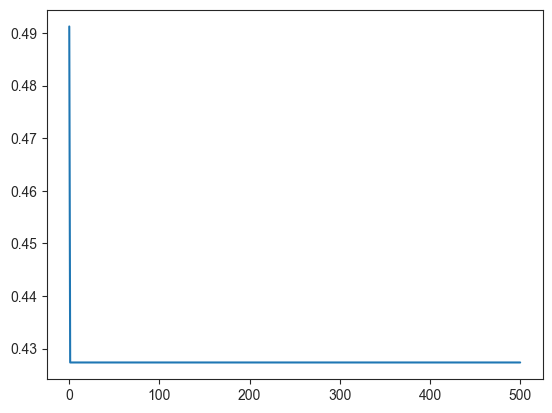

In [132]:
plt.plot(np.linspace(0,500,500),c0*np.exp(-tc*np.linspace(0,500,500))+h)

## Predict staedy state
Given $m$ observations from the quantum trajectory samples can we predict if the particle is in a steady state? We will try with different values of $m$. First we manipulate the data to get the label of steady state, with will be binery.

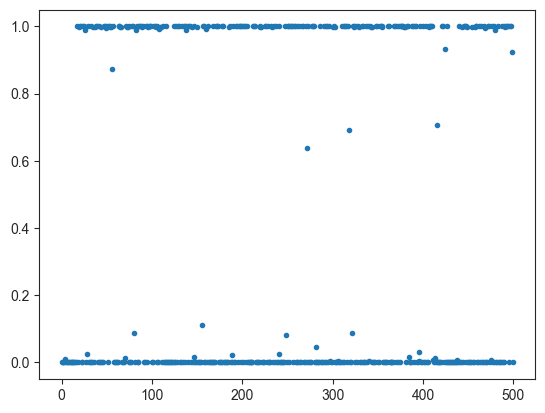

In [138]:
m = np.array([50, 100, 150]) # timesteps before checking the steady state

Pa_weak = (a_ensembe_weak**2) # shape (N_sim, N+1)

# steady state label at end of simulation
Pss = Pa_weak[:, -1]


plt.plot(Pa_weak[:,50],'.')


## Event driven simulation?

$$dx(t)=\langle x \rangle(t) dt + \sqrt{\tau_m} \cdot dW $$

With $\cdot$ representing ito integration. Since our model has non demolition measurement, the expectationvalue will actually not depend on time. $\tau_m$ are the charateristic measurement times, determined by the meter(?)

The quantum trajectory for the two level system is defined with the iterative map

$$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

In [134]:
#The measurement operator
def Sigma_x(x):
    return qt.Qobj([[phi(x-gweak), 0], [0, phi(x-gweak)]]) 

Sigma_x(1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.30113743 0.        ]
 [0.         0.30113743]]

In [135]:
#Parameters
N=10 #Number of levels in metet hilbert space 

#Operators
qt.momentum(N)
sz = qt.sigmaz()


#Initial state
psi00 = (a*qt.basis(2,0) + b*qt.basis(2,1)) 
rho0 = psi00 *psi00.dag() #pure state 

times = np.linspace(0,1,100)


NameError: name 'a' is not defined

In [ ]:
stoc_solution = qt.smesolve(
    H, rho_0, times,
    c_ops=[], #no dissipation term
    sc_ops=[np.sqrt(KAPPA) * a], #monitored operators
    e_ops=[x],
    ntraj=NUMBER_OF_TRAJECTORIES,
    options={"dt": 0.00125, "store_measurement": True,}
)

## Master equation

The von Neuman model is a closed system and it does therefore not have any dissipertive term: the measurement output (in our case this is position), will therefore not change in time